# **Spam Detection**
![title](scam.png)
The number of spam SMS messages, so-called 'smishing' has been increasing. Many of them contain fake information and a link to a malicious website, which may be used by cyber criminals to access or collect users' personal information.  
  
Security companies use a combination of different technologies. Content filtering is one of those, which adopts machine learning algorithms to detect a spam message. Naïve Bayes, SVM (Support Vector Machine), KNN (K Nearest Neighbor) and Deep Learning are widely used algorithms.  
 
This research was conducted to detect a spam message using a classical machine learning algorithm and a deep learning algorithm.  
  
For classical machine learning, I picked the Naive Bayes model because many security software companies adapted the algorithm to their product since the mid-'90s.  
For a deep learning model, I picked an LSTM model with GloVe embeddings. LSTM is an extension of RNN and was developed for sequential data like written or verbal speech. 
   
Data source: UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/sms+spam+collection#)  
A collection of 425 SMS spam messages was manually extracted from the Grumbletext Web site. This is a UK forum in which cell phone users make public claims about SMS spam messages.

## **Import Modules**

In [60]:
# Import modules 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from matplotlib import rcParams
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import re

from nltk.stem import WordNetLemmatizer

import pickle

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Set pd.options to add slide bars
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## **Basic Statistics**
* The data contains 5572 rows and 2 columns without a column header: a target variable and a feature
* Name the target variable 'label', and the feature variable 'message' respectively
* The target variable, 'label' contains 2 unique values: 'ham', 'spam'
* The data has no missing values
* The message column contains 5169 unique messages, where 4516 unique 'ham' and 653 unique 'spam'
* "Sorry, I'll call later" is the most frequent 'ham' message appearing 30 times.
* "Please call our customer service representative......" is the most frequent 'spam' message appearing 4 times.

In [3]:
# Read a tab delimitted file into Pandas DataFrame
spam = pd.read_csv('data/SMSSpamCollection', sep='\t', header=None, names=['label', 'message'])

In [4]:
spam.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# Check the data

print("------------------------------------------------------")
print("Shape of 'spam'")
print("Number of rows: ", spam.shape[0])
print("Number of columns: ", spam.shape[1])
print("------------------------------------------------------")
print("Columns")
print("Columns: ", spam.columns)
print("------------------------------------------------------")
print("Number of unique values")
print("label: ", spam['label'].nunique())
print('message: ', spam['message'].nunique())
print("Unique value in 'label': ", spam['label'].unique())
print("------------------------------------------------------")
print('Datatype')
print("Data type of 'label': ", spam['label'].dtype)
print("Data type of 'message': ", spam['message'].dtype)
print("------------------------------------------------------")

------------------------------------------------------
Shape of 'spam'
Number of rows:  5572
Number of columns:  2
------------------------------------------------------
Columns
Columns:  Index(['label', 'message'], dtype='object')
------------------------------------------------------
Number of unique values
label:  2
message:  5169
Unique value in 'label':  ['ham' 'spam']
------------------------------------------------------
Datatype
Data type of 'label':  object
Data type of 'message':  object
------------------------------------------------------


In [6]:
spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [7]:
spam.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [8]:
# Check the most frequent messages in 'ham' and 'spam'
spam.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [9]:
# Check the 10 most frequent messages
duplicated_message = spam.groupby(['message'])['label'].count().reset_index()
duplicated_message = duplicated_message[duplicated_message['label'] > 1]

print('Top 10 duplicate messages')
print(duplicated_message.sort_values('label', ascending=False).head(10))

Top 10 duplicate messages
                                                message  label
3712                             Sorry, I'll call later     30
1788  I cant pick the phone right now. Pls send a me...     12
3201                                              Ok...     10
3514  Say this slowly.? GOD,I LOVE YOU &amp; I NEED ...      4
4458  Wen ur lovable bcums angry wid u, dnt take it ...      4
92    7 wonders in My WORLD 7th You 6th Ur style 5th...      4
3339  Please call our customer service representativ...      4
4963  Your opinion about me? 1. Over 2. Jada 3. Kusr...      4
3229                                               Okie      4
3181                                                Ok.      4


### **Exploratery Data Analysis**
* 'label' contains 2 classes: 'ham' and 'spam', whose frequencies are 4825 and 747 respectively
* The data is imbalanced where almost 90% of the messages are classified as 'ham'
* Many messages contain whitespace, punctuations, a mix of uppercase and lowercase, and numbers
* Many messages contain SMS specific acronyms such as 'U', 'R', 'C', and 'UR'

In [10]:
# Check the number of the label
num_ham = spam[spam['label'] == 'ham']['label'].count()
num_spam = spam[spam['label'] == 'spam']['label'].count()
ratio_ham = num_ham/len(spam)
ratio_spam = num_spam/len(spam)

print("Number of ham: ", num_ham)
print(f"Ratio of ham:  {ratio_ham:.2%}")
print("Number of spam: ", num_spam)
print(f"Ratio of spam: {ratio_spam:.2%}")

Number of ham:  4825
Ratio of ham:  86.59%
Number of spam:  747
Ratio of spam: 13.41%


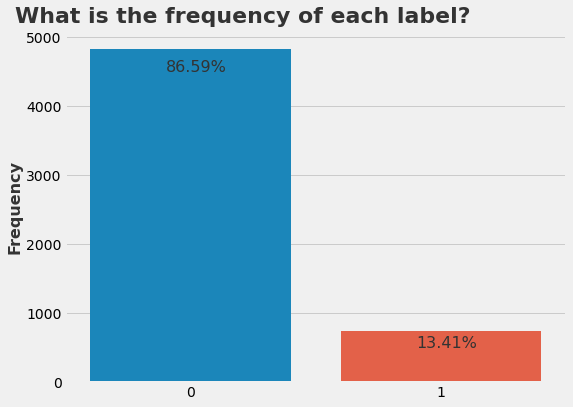

In [75]:
# Visualize the ratio of ham and spam
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(8, 6))

sns.countplot(spam['label'], ax=ax)
plt.text(x=-0.7, y=5200, s="What is the frequency of each label?", fontsize=22, fontweight='bold')
plt.text(x=-0.1, y=4500, s=f"{ratio_ham:.2%}", fontsize=16)
plt.text(x=0.9, y=500, s=f"{ratio_spam:.2%}", fontsize=16)
plt.xlabel("")
plt.ylabel("Frequency", fontsize=16, fontweight='bold');

##### **Visualize Distribution**
* The boxplot shows the average word count in spam messages is greater than ham
* Spam message word count has no outliers, while ham message has many outliers
* The average word count of ham is 14.31, while the average word count of spam is 23.91
* Spam message word count shows left-skewed distribution, while ham message word count is right skewed

In [12]:
# Add a new column 'num_words' to keep the length of the messages
spam['num_words'] = [len(msg.split()) for msg in spam['message']]
spam.head()

,label,message,num_words
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


In [13]:
# Check the number of words by label
ham_num_words_stat = spam[spam['label'] == 'ham']['num_words'].agg(['mean', 'min', 'max'])
spam_num_words_stat = spam[spam['label'] == 'spam']['num_words'].agg(['mean', 'min', 'max'])

print("---- Number of words in ham ----")
print(f"Mean: {ham_num_words_stat[0]:.2f}")
print(f"Minimum: {ham_num_words_stat[1]}")
print(f"Maximum: {ham_num_words_stat[2]}\n")

print("----- Number of words in spam -----")
print(f"Mean: {spam_num_words_stat[0]:.2f}")
print(f"Minimum: {spam_num_words_stat[1]}")
print(f"Maximum: {spam_num_words_stat[2]}")

---- Number of words in ham ----
Mean: 14.31
Minimum: 1.0
Maximum: 171.0

----- Number of words in spam -----
Mean: 23.91
Minimum: 2.0
Maximum: 35.0


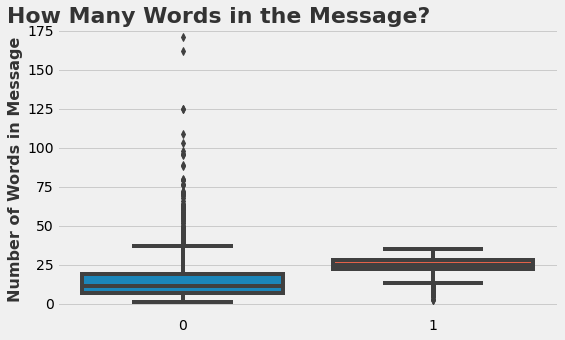

In [76]:
# Create a boxplot to display the length
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(8, 5))

sns.boxplot(spam['label'], spam['num_words'])
plt.text(x=-0.7, y=180, s="How Many Words in the Message?", fontsize=22, fontweight='bold')
plt.xlabel("")
plt.ylabel("Number of Words in Message", fontsize=16, fontweight='bold');

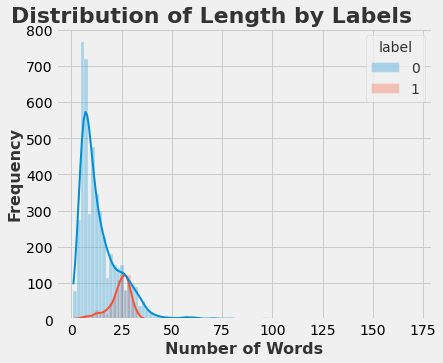

In [77]:
# Check the distribution of the length by ham and spam
plt.style.use('fivethirtyeight')
plt.subplots(figsize=(6, 5))

sns.histplot(data=spam, x='num_words', hue='label', kde=True, alpha=0.3, line_kws={"lw":2})
plt.text(x=-30, y=820, s="Distribution of Length by Labels", fontsize=22, fontweight='bold')
plt.xlabel("Number of Words", fontsize=16, fontweight='bold')
plt.ylabel("Frequency", fontsize=16, fontweight='bold');

##### **Visualize Word Frequency**
* Simple wordcloud visualizations show the frequency of words used in 'ham' and 'spam' respectively
* Messages were not preprocessed
* Stopwords were removed
* In 'spam', 'FREE', 'call', 'text', 'mobile', and 'txt' are outstanding 
* Besides those words, 'claim', 'STOP', 'WON', 'reply', and 'prize' are seen

In [16]:
# Split 'message' into pieces of string
ham_words = " ".join(word for word in spam[spam['label'] == 'ham']['message'])
spam_words = " ".join(word for word in spam[spam['label'] == 'spam']['message'])

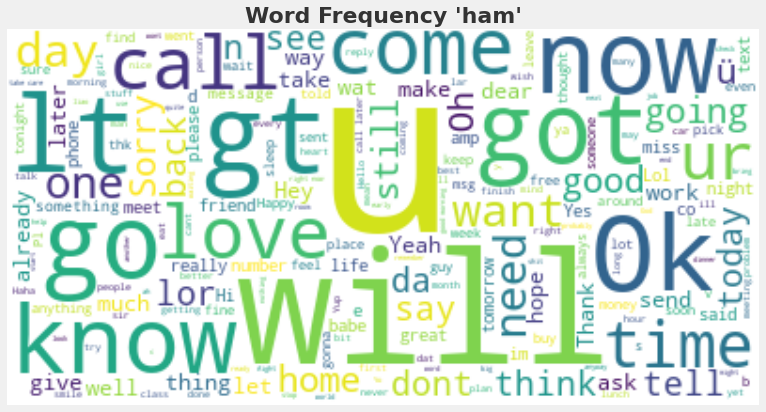

In [78]:
# Visualize 'ham' word frequency
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(ham_words)
plt.figure( figsize=(12, 8))
plt.title("Word Frequency 'ham'", fontsize=22, fontweight='bold')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

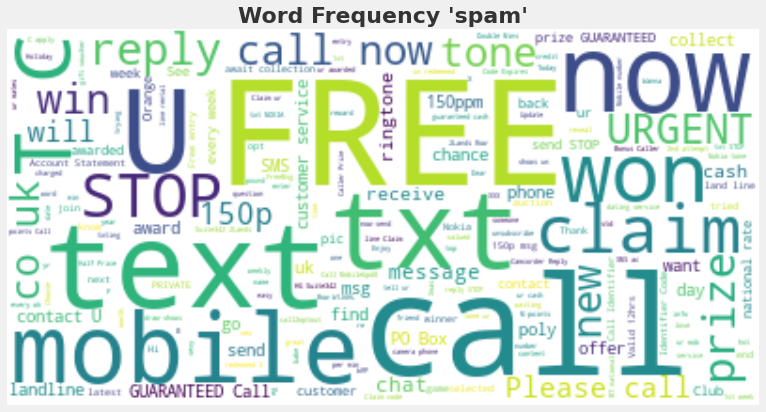

In [79]:
# Visualize 'ham' word frequency
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(spam_words)
plt.figure( figsize=(12, 8))
plt.title("Word Frequency 'spam'", fontsize=22, fontweight='bold')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

## **Naive Bayes Classifier Model**
* Bayes Theorem calculates a conditional probability of independent events based on prior knowledge, it's been used for commercial spam filtering since the mid-'90s.
* When given a condition that a message is spam, the model will calculate the probability of the message containing certain words.
* It will learn the likelihood of a word appearing in spam and predict whether a message is a spam or not.

#### **Text Preprocessing**
* Before training a model, messages need to be clean to achieve a better performance
1. Convert all characters to lowercase
2. convert acronyms, 'u', 'c', 'r' to 'you', 'see', 'are'
3. Tokenize 'message'
4. Remove special characters, numbers and URLs
5. Remove stopwords
6. Lemmatize words

In [20]:
# 1. Convert all characters to lowercase
spam['message'] = [txt.lower() for txt in spam['message']]


In [21]:
# Chec some samples
print(spam['message'][3])
print(spam['message'][9])

u dun say so early hor... u c already then say...
had your mobile 11 months or more? u r entitled to update to the latest colour mobiles with camera for free! call the mobile update co free on 08002986030


In [22]:
# 2. convert acronyms, 'u', 'c', 'r', 'ur' to 'you', 'see', 'are', 'you're'

# 'u' --> 'you'
spam['message'] = [re.sub(r"(^u\s)", 'you ',txt) for txt in spam['message']]
spam['message'] = [re.sub(r"(\su\s)", ' you ',txt) for txt in spam['message']]
spam['message'] = [re.sub(r"(\su$)", ' you',txt) for txt in spam['message']]

# 'c' --> 'see'
spam['message'] = [re.sub(r"(^c\s)", 'see ',txt) for txt in spam['message']]
spam['message'] = [re.sub(r"(\sc\s)", ' see ',txt) for txt in spam['message']]
spam['message'] = [re.sub(r"(\sc$)", ' see',txt) for txt in spam['message']]

# 'r' --> 'are'
spam['message'] = [re.sub(r"(^r\s)", 'are ',txt) for txt in spam['message']]
spam['message'] = [re.sub(r"(\sr\s)", ' are ',txt) for txt in spam['message']]
spam['message'] = [re.sub(r"(\sr$)", ' are',txt) for txt in spam['message']]

# 'ur' --> 'you're'
spam['message'] = [re.sub(r"(^ur\s)", 'are ',txt) for txt in spam['message']]
spam['message'] = [re.sub(r"(\sur\s)", ' are ',txt) for txt in spam['message']]
spam['message'] = [re.sub(r"(\sur$)", ' are',txt) for txt in spam['message']]

In [23]:
# Check 'u', 'c', 'r' were converted to 'you', 'see', 'are' 
print(spam['message'][3])
print(spam['message'][9])

you dun say so early hor... you see already then say...
had your mobile 11 months or more? you are entitled to update to the latest colour mobiles with camera for free! call the mobile update co free on 08002986030


In [24]:
# 3. Tokenize 'message'
tokens = [word_tokenize(txt) for txt in spam['message']]

In [25]:
# 4. Remove special characters, numbers and URLs

# Remove special characters and numbers
tokens = [[word for word in token if word.isalpha()]for token in tokens]

In [26]:
# Check special characters and numbers were removed
print(tokens[3])
print(tokens[9])

['you', 'dun', 'say', 'so', 'early', 'hor', 'you', 'see', 'already', 'then', 'say']
['had', 'your', 'mobile', 'months', 'or', 'more', 'you', 'are', 'entitled', 'to', 'update', 'to', 'the', 'latest', 'colour', 'mobiles', 'with', 'camera', 'for', 'free', 'call', 'the', 'mobile', 'update', 'co', 'free', 'on']


In [27]:
# 5. Remove stopwords
sw = stopwords.words("english")
tokens = [[word for word in token if word not in sw] for token in tokens]

In [28]:
# Check stopwords were removed
print(tokens[3])
print(tokens[9])

['dun', 'say', 'early', 'hor', 'see', 'already', 'say']
['mobile', 'months', 'entitled', 'update', 'latest', 'colour', 'mobiles', 'camera', 'free', 'call', 'mobile', 'update', 'co', 'free']


In [29]:
# 6. Lemmatize words
#nltk.download('wordnet')
 
# Instantiate WordNetLemmatizer
wnl = WordNetLemmatizer()

tokens = [[wnl.lemmatize(word) for word in token] for token in tokens]

In [30]:
# Check the result of lemmatization
print(tokens[3])
print(tokens[9])

['dun', 'say', 'early', 'hor', 'see', 'already', 'say']
['mobile', 'month', 'entitled', 'update', 'latest', 'colour', 'mobile', 'camera', 'free', 'call', 'mobile', 'update', 'co', 'free']


#### **Visualize Wordcloud of Cleaned Message**
* 'free', 'call', 'text', 'mobile', 'reply', and 'stop' are outstanding in the Wordcloud with cleaned spam data 

In [31]:
# Add tokens to spam
spam['tokens'] = tokens
spam.head()

,label,message,num_words,tokens
0,ham,"go until jurong point, crazy.. available only ...",20,"[go, jurong, point, crazy, available, bugis, n..."
1,ham,ok lar... joking wif you oni...,6,"[ok, lar, joking, wif, oni]"
2,spam,free entry in 2 a wkly comp to win fa cup fina...,28,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,you dun say so early hor... you see already th...,11,"[dun, say, early, hor, see, already, say]"
4,ham,"nah i don't think he goes to usf, he lives aro...",13,"[nah, think, go, usf, life, around, though]"


In [32]:
# Convert a list of tokens to a string
ham_tokens = ""
for token in spam[spam['label'] == 'ham']['tokens']:
    for word in token:
        ham_tokens += (word + ' ' )

spam_tokens = ""
for token in spam[spam['label'] == 'spam']['tokens']:
    for word in token:
        spam_tokens += (word + ' ' )

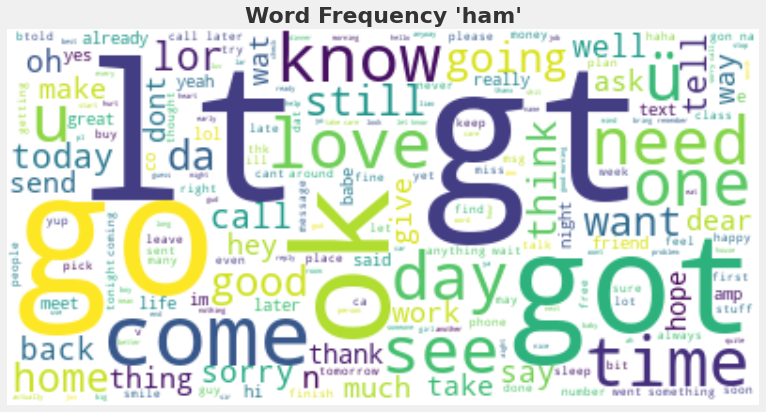

In [80]:
wordcloud_cleaned_ham = WordCloud(background_color="white").generate(ham_tokens)
plt.figure( figsize=(12, 8))
plt.title("Word Frequency 'ham'", fontsize=22, fontweight='bold')
plt.imshow(wordcloud_cleaned_ham, interpolation='bilinear')
plt.axis("off");

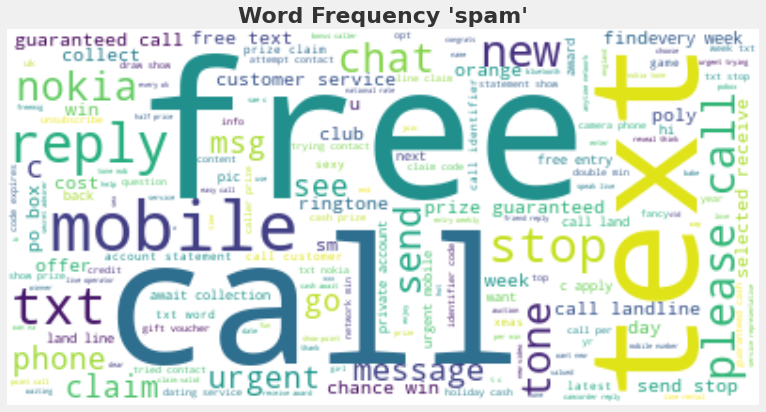

In [81]:
wordcloud_cleaned_spam = WordCloud(background_color="white").generate(spam_tokens)
plt.figure( figsize=(12, 8))
plt.title("Word Frequency 'spam'", fontsize=22, fontweight='bold')
plt.imshow(wordcloud_cleaned_spam, interpolation='bilinear')
plt.axis("off");

#### **Create Naive Bayes Model**

* The data is imbalanced, so use stratify parameter so that the data will be proportioned 
* Use TfidfVectorizer to vectorize each word in messages

In [35]:
# Replace 'ham' and 'spam' to 0 and 1
dict = {'ham': 0, 'spam': 1}
spam['label'] = spam['label'].replace(dict)

In [61]:
# Create a train and test datasets
X = spam['tokens'].astype(str)
y = spam['label']

In [62]:
# Split train and test dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

In [63]:
# Create TfidfVectorizer
vect = TfidfVectorizer()
vect.fit(X_train)

# Transform and vectorize X_train and X_test
X_train_vect = vect.transform(X_train)
X_test_vect = vect.transform(X_test)

In [64]:
# Create GaussianNB model
model = MultinomialNB()
model.fit(X_train_vect.toarray(), y_train)

MultinomialNB()

In [65]:
# Predict
y_pred = model.predict(X_test_vect.toarray())

#### **Performance of Bayes Model**
* The accuracy rate of the training dataset is 97.36%, while the test dataset is 96.59%
* The overall accuracy rate is 97%, precision is 100% and recall is 74.55%
* The F1 score is 0.85.
* The Recall of 74.55% means that the model failed to detect 57 spam messages, or detected 25.45% of spam as ham.
* The Precision of 99.44% means that the model misclassified 1 ham message as spam
* It can be said that the model performs very well

In [66]:
# Check the performance of the model
train_accuracy = model.score(X_train_vect.toarray(), y_train)
print(f"Train Dataset Accuracy: {train_accuracy:.2%}")

test_accuracy = model.score(X_test_vect.toarray(), y_test)
print(f"Test Dataset Accuracy: {test_accuracy:.2%}")

Train Dataset Accuracy: 97.36%
Test Dataset Accuracy: 96.59%


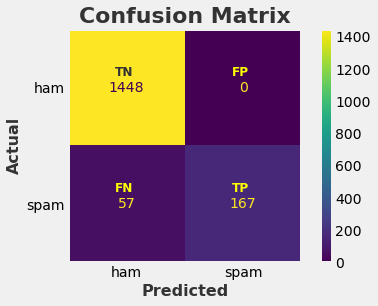

In [82]:
# Visualize the confusion_matrix
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
confusion_matrix_plot.plot()

plt.title("Confusion Matrix", fontsize=22, fontweight='bold')
font_color = {'color': 'yellow'}
plt.text(x=-0.1, y=-0.1, s="TN", fontsize=12, fontweight='bold')
plt.text(x=-0.1, y=0.9, s="FN", fontsize=12, fontweight='bold', fontdict=font_color)
plt.text(x=0.9, y=0.9, s="TP", fontsize=12, fontweight='bold', fontdict=font_color)
plt.text(x=0.9, y=-0.1, s="FP", fontsize=12, fontweight='bold', fontdict=font_color)
plt.xlabel("Predicted", fontsize=16, fontweight='bold')
plt.ylabel("Actual", fontsize=16, fontweight='bold')
plt.xticks([False, True], ['ham', 'spam'])
plt.yticks([False, True], ['ham', 'spam'])
plt.grid(False);

In [83]:
# TP, FP, TN, FN
true_positive = cm[1, 1]
false_positive = cm[0, 1]
true_negative = cm[0, 0]
false_negative = cm[1, 0]
print(f"True Positive: {true_positive}")
print(f"False Positive: {false_positive}")
print(f"True Negative: {true_negative}")
print(f"False Negative: {false_negative}")

print("---------------------------------------")
# Accuracy Rate
accuracy_rate = (true_negative + true_positive) / cm.sum()
accuracy_rate = round(accuracy_rate, 2)
print(f"Accuracy Rate: {accuracy_rate:.2%}")

# Precision
precision = true_positive / (false_positive + true_positive)
print(f"Precision: {precision:.2%}")

# Recall
recall = true_positive / (false_negative + true_positive) 
print(f"Recall: {recall:.2%}")

# F1 Score
f1 = 2 * (precision * recall) / (precision + recall)
print(f"F1 Score: {f1:.2}")

True Positive: 167
False Positive: 0
True Negative: 1448
False Negative: 57
---------------------------------------
Accuracy Rate: 97.00%
Precision: 100.00%
Recall: 74.55%
F1 Score: 0.85


## **Deep Learning Model**
* A bidirectional LSTM model is used for a deep learning model
* LSTM is an extension of RNN, which was designed to handle sequential data such as video, speech, and text
* This model also uses pre-trained embeddings, GloVe 6B 50, which contains 6 billion tokens, 400,000 vocabularies and 50 dimensions.
* GloVe 6B 50 was downloaded from the Stanford University website (https://nlp.stanford.edu/projects/glove/). 
 
* The cleaned spam dataset used for the Naive Bayes model is used for a deep learning model

#### **Import Modules**
* Import modules for an LSTM model

In [84]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import *
from keras.utils.np_utils import to_categorical
from keras.initializers import Constant

#### **Load Data**
* The already cleaned spam dataframe is used 

In [85]:
# Copy spam as spam2
spam2 = spam.copy()

# Check the distribution of word count of messages
spam2['num_words'].describe()

count    5572.000000
mean       15.597452
std        11.404053
min         1.000000
25%         7.000000
50%        12.000000
75%        23.000000
max       171.000000
Name: num_words, dtype: float64

In [86]:
# Only use 'label' and 'tokens' columns
spam2.drop(['message', 'num_words'], axis=1, inplace=True)
spam2.head()

,label,tokens
0,0,"[go, jurong, point, crazy, available, bugis, n..."
1,0,"[ok, lar, joking, wif, oni]"
2,1,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,0,"[dun, say, early, hor, see, already, say]"
4,0,"[nah, think, go, usf, life, around, though]"


In [87]:
# Create a train and test datasets
X2 = spam2['tokens']
y2 = spam2['label']

#### **Prepare Train and Test Datasets** ####
1. Split spam2 into training and test datasets
2. Tokenize and create vocabularies of training datasets
3. Create a sequence by mapping each token to a number
4. Pad 0 if the sequence is less than 50

In [88]:
# 1. Split spam2 into training and test datasets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=123, stratify=y)

In [89]:
# Check the number of unique words in 'tokens' 
token_set = set([word for token in spam2['tokens'] for word in token])
print("Number of Vocabularies:", len(token_set))

Number of Vocabularies: 6711


#### **Tokenize the Training Data and Make a Sequence Representation**
* Separate each word in a message to create vocabularies of tokens
* Assign an integer to each word

In [90]:
# Determine parameters to pass to Tokenizer()
num_vocabularies = 1000 # num_words
oov_token = '<unk>' # oov_token

# Determine parameters to pass to pad_sequences()
sequence_length = 50 # maxlen
padding = 'post' # padding
truncating ='post' # truncating

In [91]:
# 2. Tokenize and create vocabralies of training datasets
tokenizer = Tokenizer(num_words=num_vocabularies, oov_token=oov_token)
tokenizer.fit_on_texts(X2_train)

In [92]:
# Display the first 10 tokens
word_index = tokenizer.word_index
list(word_index.items())[:10]

[('<unk>', 1),
 ('call', 2),
 ('get', 3),
 ('go', 4),
 ('gt', 5),
 ('lt', 6),
 ('know', 7),
 ('free', 8),
 ('come', 9),
 ('time', 10)]

In [93]:
# 3. Mapp each token to a number
X2_train_seq = tokenizer.texts_to_sequences(X2_train)

#### **Pad Each Sequence**
* Add 0 to a list of tokens so that the lengh of list becomes 50

In [94]:
# 4. Padd 0 if the sequence is less than 50
X2_train_padded = pad_sequences(X2_train_seq, maxlen=sequence_length, padding=padding, truncating=truncating)

In [96]:
# Check the padded training data
X2_train_padded 

array([[199,  89, 391, ...,   0,   0,   0],
       [ 51, 451,   0, ...,   0,   0,   0],
       [120,   1,   1, ...,   0,   0,   0],
       ...,
       [483, 218,  21, ...,   0,   0,   0],
       [148, 156, 729, ...,   0,   0,   0],
       [430,   1, 828, ...,   0,   0,   0]])

In [97]:
# 3. Mapp each token to a number
# 4. Padd 0 if the sequence is less than 50
X2_test_seq = tokenizer.texts_to_sequences(X2_test)
X2_test_padded = pad_sequences(X2_test_seq, maxlen=sequence_length, padding=padding, truncating=truncating)

#### **Load GloVe 6B Embedding**
* The pre-trained word vector, GloVe 6B 50 was downloaded from Stanford University website (https://nlp.stanford.edu/projects/glove/). 
* It contains 400,000 vocabularies. Each vocabulary has 50 dimmensions.

In [98]:
# Load GloVe 6B
with open('data\glove.6B.50d.txt', 'rt', encoding='utf8') as f:
    emb = f.readlines()

In [99]:
# View the first word of emb
print(emb[0])

# Check the data type of emb
print(f"emb is a {type(emb)} of {type(emb[0])}\n")

# Check the shape of emb
print(f"emb contains {len(emb)} words")

the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.49688 -0.17862 -0.00066023 -0.6566 0.27843 -0.14767 -0.55677 0.14658 -0.0095095 0.011658 0.10204 -0.12792 -0.8443 -0.12181 -0.016801 -0.33279 -0.1552 -0.23131 -0.19181 -1.8823 -0.76746 0.099051 -0.42125 -0.19526 4.0071 -0.18594 -0.52287 -0.31681 0.00059213 0.0074449 0.17778 -0.15897 0.012041 -0.054223 -0.29871 -0.15749 -0.34758 -0.045637 -0.44251 0.18785 0.0027849 -0.18411 -0.11514 -0.78581

emb is a <class 'list'> of <class 'str'>

emb contains 400000 words


In [100]:
# Split emb into a vocabulary and vector and create a dictionary: emb_index[word] = vector
emb_index = {}
for element in emb:
    word = element.split()[0] # word
    vector = [float(n) for n in element.split()[1:]] # vector: convert from string to float
    emb_index[word] = vector

In [101]:
# Print the 5th vocabulary and vector
print("The 1st vocabulary: ", list(emb_index.keys())[0])
print("The 1st vocabulary's vector: ", emb_index[list(emb_index.keys())[0]])

The 1st vocabulary:  the
The 1st vocabulary's vector:  [0.418, 0.24968, -0.41242, 0.1217, 0.34527, -0.044457, -0.49688, -0.17862, -0.00066023, -0.6566, 0.27843, -0.14767, -0.55677, 0.14658, -0.0095095, 0.011658, 0.10204, -0.12792, -0.8443, -0.12181, -0.016801, -0.33279, -0.1552, -0.23131, -0.19181, -1.8823, -0.76746, 0.099051, -0.42125, -0.19526, 4.0071, -0.18594, -0.52287, -0.31681, 0.00059213, 0.0074449, 0.17778, -0.15897, 0.012041, -0.054223, -0.29871, -0.15749, -0.34758, -0.045637, -0.44251, 0.18785, 0.0027849, -0.18411, -0.11514, -0.78581]


#### **Map the Vector Representation of GloVe Embedding to Vocabularies** ####
* Add GloVe matrix vector representation to each word in X2_train 
1. Loop word_index and take word and its number
2. If the word is included in emb_index, get the corresponding vector representation
3. Add the vector representation at the idx th of the emb_vector array

In [102]:
# Populate the vector in the same position as the sequence created from the training data
emb_vector = np.zeros((len(word_index) + 1, sequence_length))
for word, idx in word_index.items(): #word_index = {'word': idx}
    embedding_vector = emb_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        emb_vector[idx] = embedding_vector

In [103]:
# Verify the vector for the word, 'get' in GloVe 6B (emb_index) is the same as the one in the array ('emb_vector')
idx = word_index['get']
print(emb_index.get('get'))
print("---------------------------------------------------------------------------------------------------------")
print(emb_vector[idx])

[0.1591, -0.21428, 0.63099, -0.5995, 0.31248, -0.16615, -0.90548, 0.45115, 0.051568, 0.2591, -0.32882, 0.48155, -0.34982, 0.12905, 1.0758, 0.4869, 0.5342, 0.059762, 0.2166, -1.1059, -0.25591, 0.57462, 0.54562, 0.31043, 0.37765, -2.0337, -0.22496, 0.18447, 0.82587, -1.1991, 3.6042, 1.1605, -0.59787, 0.13, 0.15678, 0.13166, 0.1851, 0.36308, 0.57538, -0.89593, -0.36366, 0.28397, 0.048614, 0.7878, -0.087311, -0.23394, -0.14237, 0.021215, -0.14219, 0.66955]
---------------------------------------------------------------------------------------------------------
[ 0.1591   -0.21428   0.63099  -0.5995    0.31248  -0.16615  -0.90548
  0.45115   0.051568  0.2591   -0.32882   0.48155  -0.34982   0.12905
  1.0758    0.4869    0.5342    0.059762  0.2166   -1.1059   -0.25591
  0.57462   0.54562   0.31043   0.37765  -2.0337   -0.22496   0.18447
  0.82587  -1.1991    3.6042    1.1605   -0.59787   0.13      0.15678
  0.13166   0.1851    0.36308   0.57538  -0.89593  -0.36366   0.28397
  0.048614  0.787

#### **Create LSTM Model** ####
* The emb_vector is injected in the Embedding layer as weights
* As the pretrained embeddings is used, the trainable parameter is set to False

In [104]:
# Create an Embedding layer using emb_vector as weights
embedding_layer = Embedding(len(word_index) + 1,
                            sequence_length,
                            weights=[emb_vector],
                            input_length=sequence_length,
                            trainable=False)

In [105]:
# Create a bidirectional LSTM model
embedding_dim = 16
input_length = 100
model = Sequential([
    embedding_layer,
  Bidirectional(LSTM(embedding_dim, return_sequences=True)),
  Bidirectional(LSTM(embedding_dim,)),
  Dense(6, activation='relu'),
  Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [106]:
# Check the model parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            282450    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 32)           8576      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 198       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 297,503
Trainable params: 15,053
Non-train

In [107]:
# Train the model
n_epochs = 10
history = model.fit(X2_train_padded, y2_train, epochs=n_epochs, validation_data=(X2_test_padded, y2_test))

Epoch 1/10
122/122 [==============================] - 13s 44ms/step - loss: 0.3486 - accuracy: 0.8787 - val_loss: 0.1563 - val_accuracy: 0.9557
Epoch 2/10
122/122 [==============================] - 4s 34ms/step - loss: 0.1403 - accuracy: 0.9528 - val_loss: 0.1232 - val_accuracy: 0.9611
Epoch 3/10
122/122 [==============================] - 5s 39ms/step - loss: 0.1152 - accuracy: 0.9626 - val_loss: 0.1121 - val_accuracy: 0.9677
Epoch 4/10
122/122 [==============================] - 5s 42ms/step - loss: 0.0987 - accuracy: 0.9687 - val_loss: 0.0987 - val_accuracy: 0.9707
Epoch 5/10
122/122 [==============================] - 5s 45ms/step - loss: 0.0894 - accuracy: 0.9715 - val_loss: 0.0923 - val_accuracy: 0.9743
Epoch 6/10
122/122 [==============================] - 6s 48ms/step - loss: 0.0776 - accuracy: 0.9785 - val_loss: 0.0881 - val_accuracy: 0.9761
Epoch 7/10
122/122 [==============================] - 7s 57ms/step - loss: 0.0698 - accuracy: 0.9805 - val_loss: 0.0878 - val_accuracy: 0.975

#### **Performance of LSTM Model** ####
* The accuracy of the training data started at 0.8787 and continued to increase to 0.9862.
* On the other hand, the accuracy of the test data started at 0.9557 and continued to increase, although the change was not visible.
* Loss of training data started at 0.3486 and continued to decrease to 0.0524.
* Loss of test data started at 0.1563 and continued to decrease, but did not change much after the fifth epoch.
* After the fifth epoch, the training data exceeded the test data in accuracy.
* After the 5th epoch, the loss of the training data became lower than those of the test data.
* The overall performance of the bidirectional LSTM model is high.

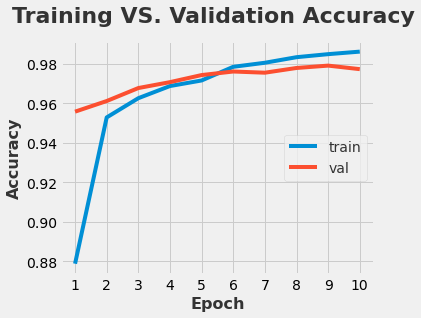

In [113]:
# Visualize the ratio of ham and spam
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(5, 4))
plt.text(x=-2, y=1.001, s="Training VS. Validation Accuracy", fontsize=22, fontweight='bold')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch", fontsize=16, fontweight='bold')
plt.ylabel("Accuracy", fontsize=16, fontweight='bold')
plt.xticks(range(10), range(1, 11))
plt.legend(['train', 'val'], loc='center right');

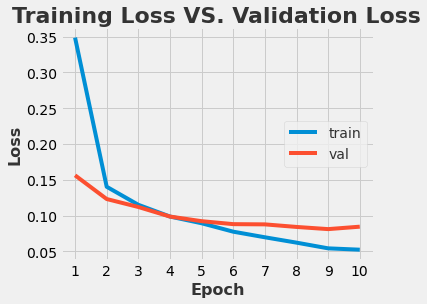

In [112]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(5, 4))
plt.text(x=-2, y=0.37, s="Training Loss VS. Validation Loss", fontsize=22, fontweight='bold')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel("Epoch", fontsize=16, fontweight='bold')
plt.ylabel("Loss", fontsize=16, fontweight='bold')
plt.xticks(range(10), range(1, 11))
plt.legend(['train', 'val'], loc='center right');